In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import torch
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from data_cleaning import clean_data

In [49]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

train_data = clean_data(train_data)
test_data = clean_data(test_data)

x_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"]

In [50]:
# Baseline: Random using prior
survival_prior = train_data["Survived"].mean()
print("Prior prob. of survival: {:.2f}".format(survival_prior))
predictions = np.random.choice([0,1], len(train_data), p=[1-survival_prior, survival_prior])
print("Accuracy: {:.2f}".format(accuracy_score(y_train, predictions)))

Prior prob. of survival: 0.38
Accuracy: 0.56


Accuracy: 0.80


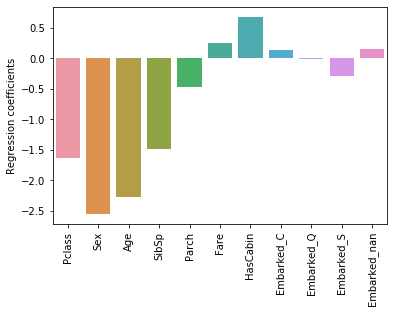

In [51]:
# Logistic regression
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_train)
test_scaled = scaler.transform(test_data)

logistic_regression = LogisticRegression(solver="lbfgs")
logistic_regression.fit(x_scaled, y_train)

predictions = logistic_regression.predict(x_scaled)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, predictions)))
coeff_bars = sns.barplot(x_train.columns, logistic_regression.coef_[0])
coeff_bars.set_ylabel("Regression coefficients")
for item in coeff_bars.get_xticklabels():
    item.set_rotation("vertical")

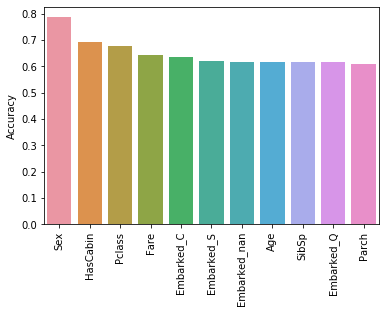

In [52]:
# Single-feature regressions
accuracies = {}
for independent_variable in x_train.columns:
    x_train_small = train_data[[independent_variable]]
    scaler = MinMaxScaler()
    x_scaled_small = scaler.fit_transform(x_train_small)
    logistic_regression = LogisticRegression(solver="lbfgs")
    logistic_regression.fit(x_scaled_small, y_train)
    predictions = logistic_regression.predict(x_scaled_small)
    acc = accuracy_score(y_train, predictions)
    accuracies[independent_variable] = acc
accuracies_ordered = collections.OrderedDict({k: v for k, v in sorted(accuracies.items(), key=lambda item: item[1], reverse=True)})
acc_bars = sns.barplot(list(accuracies_ordered.keys()), list(accuracies_ordered.values()))
acc_bars.set_ylabel("Accuracy")
for item in acc_bars.get_xticklabels():
    item.set_rotation("vertical")

In [53]:
# Bayesian inference on sex

posteriors = {}
for sex in range(2):
    # likelihood: Probability of sex given survived
    joint_probability = len(train_data[(train_data["Survived"] == 1) & (train_data["Sex"] == sex)]) / len(train_data)
    likelihood = joint_probability / survival_prior

    # evidence: Number of sex / number of passengers
    evidence = len(train_data[train_data["Sex"] == sex]) / len(train_data)
    posterior = (likelihood * survival_prior) / evidence
    posteriors[sex] = posterior
def draw_survived(x):
    return np.random.choice([0,1], p=[1-posteriors[x], posteriors[x]])
predictions = x_train["Sex"].apply(draw_survived)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, predictions)))

Accuracy: 0.67


In [54]:
# Gaussian Naive Bayes classifier using sex, age and fare
features = ["Sex", "Age",  "Fare"]
gnb = GaussianNB()
x_train_small = x_train[features]
predictions = gnb.fit(x_train_small, y_train).predict(x_train_small)
print("Accuracy GaussianNB (Sex, Age, Fare): {:.2f}".format(accuracy_score(y_train, predictions)))

for feature in features:
    gnb = GaussianNB()
    x_train_feat = x_train[feature].to_numpy()
    x_train_feat = np.expand_dims(x_train_feat, -1)
    predictions = gnb.fit(x_train_feat, y_train).predict(x_train_feat)
    print("Accuracy GaussianNB ({}): {:.2f}".format(feature, accuracy_score(y_train, predictions)))

    
bnb = BernoulliNB()
x_train_feat = x_train["Sex"].to_numpy()
x_train_feat = np.expand_dims(x_train_feat, -1)
predictions = bnb.fit(x_train_feat, y_train).predict(x_train_feat)
print("Accuracy BernoulliNB (Sex): {:.2f}".format(accuracy_score(y_train, predictions)))


Accuracy GaussianNB (Sex, Age, Fare): 0.78
Accuracy GaussianNB (Sex): 0.79
Accuracy GaussianNB (Age): 0.62
Accuracy GaussianNB (Fare): 0.67
Accuracy BernoulliNB (Sex): 0.79


In [76]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def acc(output, label):
    pred = output >= 0.5
    target = label >= 0.5
    return pred.eq(target).sum() / float(target.numel())

def train(model: torch.nn.Module, inputs: torch.Tensor, labels: torch.Tensor, n_epochs: int, batch_size: int, lr: float):
    model = model.to(device).train()
    dataset = torch.utils.data.TensorDataset(inputs, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.BCELoss()
    losses = []
    accs = []
    
    print_every = int(n_epochs / 10)
    
    for epoch in range(n_epochs):
        avg_loss = 0
        avg_acc = 0
    
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            avg_acc += acc(outputs, labels).item()
        
        avg_loss /= len(data_loader)
        avg_acc /= len(data_loader)
        if epoch % print_every == 0 or epoch == n_epochs - 1:
            print("[{} / {}] Loss: {:.5f}, acc: {:.5f}".format(epoch, n_epochs, avg_loss, avg_acc))
        losses.append(avg_loss)
        accs.append(avg_acc)

    return losses, accs

In [56]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_train.to_numpy())
input_tensor = torch.from_numpy(x_scaled).float()
label_tensor = torch.from_numpy(y_train.to_numpy()).float().unsqueeze(-1)
print(input_tensor.size())
print(label_tensor.size())

torch.Size([891, 11])
torch.Size([891, 1])


In [58]:
# Neural net
class DenseNet(torch.nn.Module):
    def __init__(self, n_inputs, n_layers: int, width: int):
        super(DenseNet, self).__init__()
        self.input_layer = torch.nn.Linear(n_inputs, width)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(width, width) for _ in range(n_layers)])
        self.output_layer = torch.nn.Linear(width, 1)
    
    def forward(self, x):
        x = torch.nn.SELU()(self.input_layer(x))
        for linear_layer in self.linear_layers:
            x = torch.nn.SELU()(linear_layer(x))
        x = torch.nn.Sigmoid()(self.output_layer(x))
        return x

In [ ]:
num_epochs = 500
batch_size = 32
num_layers = 3
width = 8
learning_rate = 1e-4
model = DenseNet(input_tensor.size(-1), num_layers, width)
losses, accs = train(model, input_tensor, label_tensor, num_epochs, batch_size, learning_rate)
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(range(len(accs)), accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

[0 / 500] Loss: 0.72631, acc: 0.38356
[50 / 500] Loss: 0.47647, acc: 0.77484
[100 / 500] Loss: 0.44612, acc: 0.80923
[150 / 500] Loss: 0.43628, acc: 0.81796
